<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Monte_Carlo_Candlestick_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mplfinance
!pip install --upgrade pandas_ta

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
import datetime as dt

In [3]:
mu = 0.05
sigma = 0.07
S0 = 100
days = 500

In [5]:
def plot_candle_sticks_macd(mu, sigma, S0, days):
    e = np.random.normal(size = [24 * 60, days])

    delta_t = 1.0/(365.0 * 24 * 60)
    prev_S = S0

    list_data = []
    for jdx in range(days):
        candle_data = []

        for idx in range(24 * 60):
            next_S = prev_S * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * e[idx, jdx])
            candle_data += [next_S]
            prev_S = next_S

        list_data += [candle_data]

    S = np.array(list_data).T

    date_index = pd.DatetimeIndex([dt.date(2025, 1, 1) + dt.timedelta(delta) for delta in range(days)])

    candlestick_df = pd.DataFrame({
        'Open' : S[0, ...],
        'High' : np.max(S, axis = 0, keepdims = False),
        'Low' : np.min(S, axis = 0, keepdims = False),
        'Close' : S[-1, ...],
    }, index = date_index)

    # Step 2: Calculate technical indicators using pandas-ta
    multiple_ema = pd.concat(
        [
            candlestick_df,
            candlestick_df.ta.ema(close="Close", length=5, inplace = True),
            candlestick_df.ta.ema(close="Close", length=20, inplace = True),
            candlestick_df.ta.ema(close="Close", length=50, inplace = True),
            candlestick_df.ta.ema(close="Close", length=200, inplace = True),
            candlestick_df.ta.macd(close="Close", fast=12, slow=26, signal=9),
            candlestick_df.ta.rsi(close="Close", length=14)
        ],
        axis = 1
    )

    data_df = multiple_ema.dropna()

    display(data_df)

    plots = [
        mpf.make_addplot(data_df['EMA_5'], color='black', width=2, ylabel = '5 EMA'),
        mpf.make_addplot(data_df['EMA_20'], color='green', width=2, ylabel = '20 EMA'),
        mpf.make_addplot(data_df['EMA_50'], color='blue', width=2, ylabel = '50 EMA'),
        mpf.make_addplot(data_df['EMA_200'], color='red', width=2, ylabel = '200 EMA'),
        mpf.make_addplot(data_df["MACD_12_26_9"], panel=1, color="blue", ylabel="MACD"),
        mpf.make_addplot(data_df["MACDs_12_26_9"], panel=1, color="orange"),
        mpf.make_addplot(
            data_df["MACDh_12_26_9"],
            type="bar",
            panel=1,
            color=["green" if val >= 0 else "red" for val in data_df["MACDh_12_26_9"]],
            alpha=0.5,
        )
    ]

    mpf.plot(
        data_df,
        type="candle",  # Candlestick chart
        style="yahoo",  # Chart style
        addplot=plots,
        figscale = 4,
        panel_ratios=(3, 1)
    )

,Open,High,Low,Close,EMA_5,EMA_20,EMA_50,EMA_200,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14
2025-07-19,102.637237,103.128852,102.496110,103.095532,102.958513,103.431537,103.546334,102.329475,-0.257448,-0.125643,-0.131805,44.308456
2025-07-20,103.099604,103.119333,102.351433,102.367053,102.761360,103.330157,103.500087,102.329849,-0.308289,-0.141187,-0.167102,36.902721
2025-07-21,102.355252,102.618539,102.196901,102.492652,102.671790,103.250395,103.460580,102.331469,-0.334589,-0.133989,-0.200599,38.801931
2025-07-22,102.487008,103.463361,102.392359,103.243818,102.862466,103.249769,103.452080,102.340547,-0.291459,-0.072688,-0.218771,48.739494
2025-07-23,103.230877,103.248972,102.635250,102.740690,102.821874,103.201285,103.424182,102.344529,-0.294482,-0.060569,-0.233913,43.629194
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-05-11,107.468903,107.734095,107.326670,107.669880,107.738497,106.988282,105.695524,103.651765,0.818210,-0.036002,0.854212,63.500032
2026-05-12,107.664203,108.217185,107.502645,108.216509,107.897834,107.105256,105.794386,103.697186,0.816847,-0.029892,0.846739,67.940925
2026-05-13,108.211869,108.390723,108.107571,108.253846,108.016505,107.214646,105.890835,103.742526,0.809449,-0.029832,0.839281,68.225301
2026-05-14,108.247116,108.465040,108.017980,108.048652,108.027220,107.294075,105.975456,103.785373,0.778059,-0.048977,0.827036,64.822204


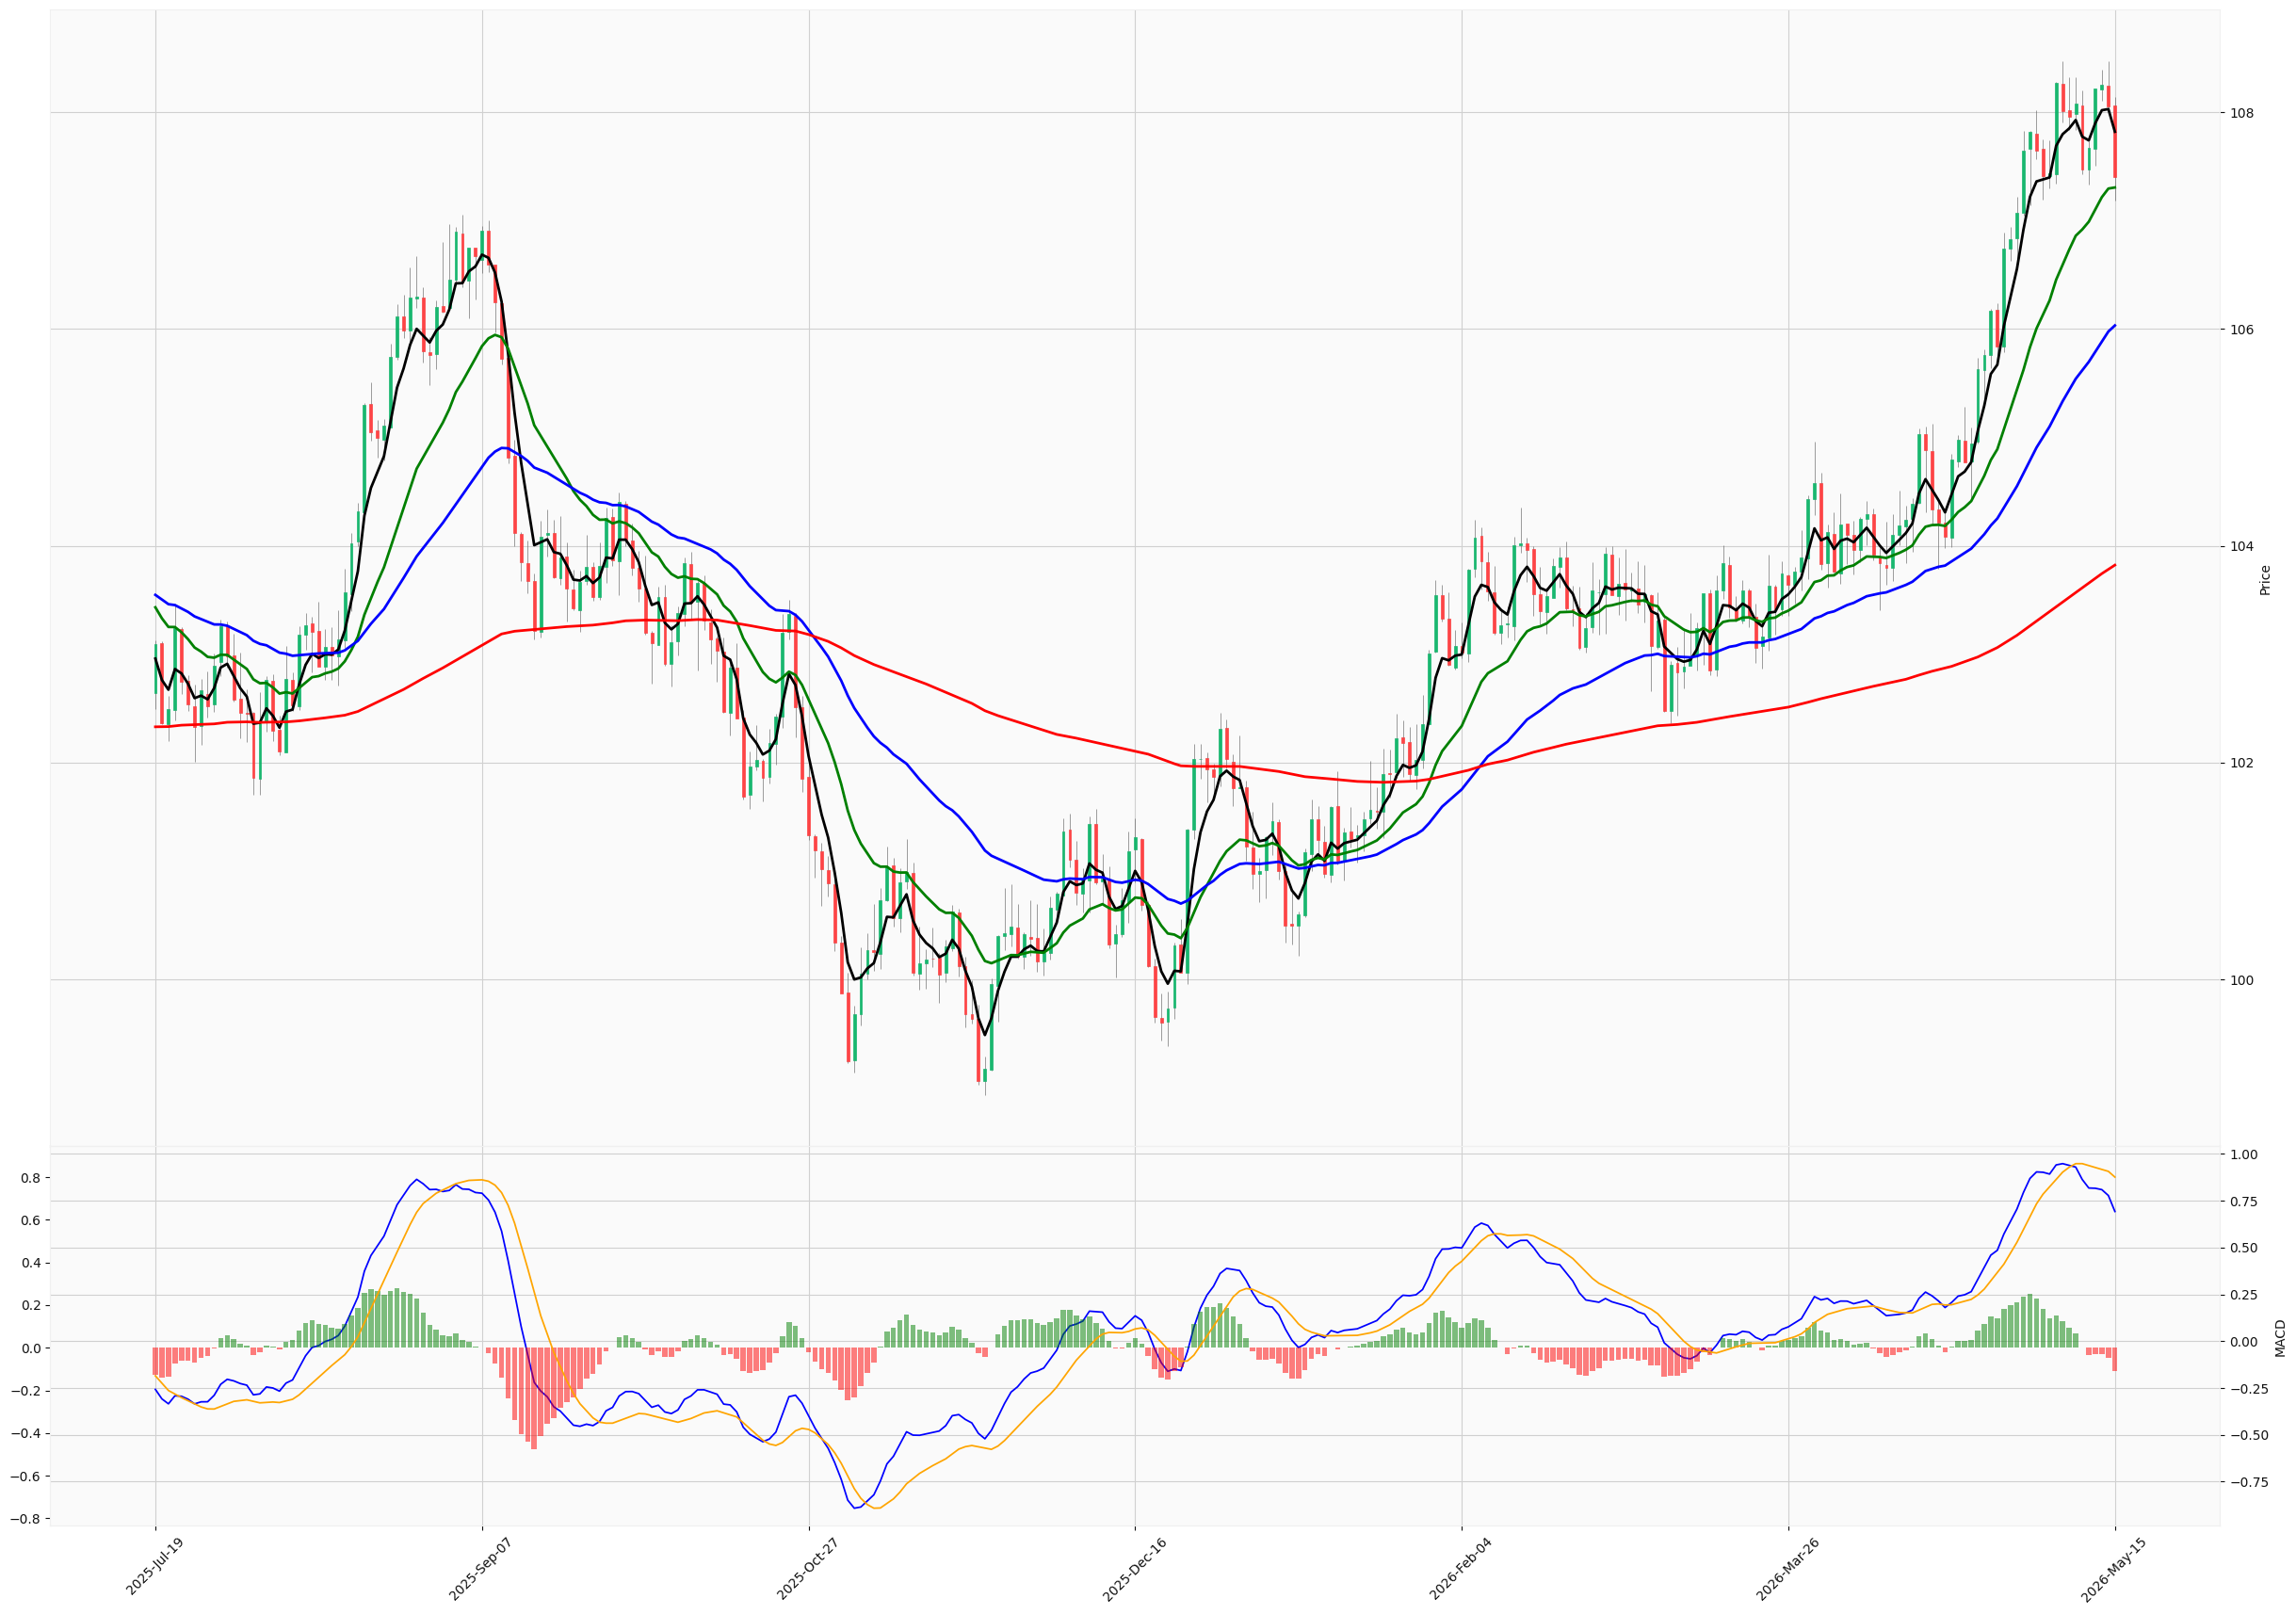

In [6]:
plot_candle_sticks_macd(mu, sigma, S0, days)